### This phase of the development notebook is mostly to figure out the TBC code, and refine the video RF decoding code.

In [1]:
# Just your usual setup

import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [2]:
pi = np.pi
tau = np.pi * 2

# Optimal if this is a power of 2
blocklenk = 2048
blocklen = (blocklenk * 1024)

In [3]:
# charting/graphing code carried over from earlier development efforts

def dosplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    db = 20 * np.log10(abs(h))

    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print("-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -10) and (db[i - 1] >= -10):
            print("<-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -20) and (db[i - 1] >= -20):
            print("<-20db crossing at ", w[i] * (freq/pi) / 2.0) 

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    plt.show()

def doplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    db = 20 * np.log10(abs(h))
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 

    ax1 = fig.add_subplot(111)

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# plot two filters (haven't tested in a long while!)
def doplot2(B, A, B2, A2, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)
    w2, h2 = sps.freqz(B2, A2)

    begin = 0
    end = len(w)
    chop = 0

    w = w[begin:end]
    w2 = w2[begin:end]
    h = h[begin:end]
    h2 = h2[begin:end]

    v = np.empty(len(w))

    hm = np.absolute(h)
    hm2 = np.absolute(h2)

    v0 = hm[0] / hm2[0]
    for i in range(0, len(w)):
        v[i] = (hm[i] / hm2[i]) / v0

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    v  = 20 * np.log10(v )

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'r')
    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h2)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    angles2 = np.unwrap(np.angle(h2))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.plot(w * (freq/pi) / 2.0, angles2, 'y')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# This matches FDLS-based conversion surprisingly well (i.e. FDLS is more accurate than I thought ;) )
def BA_to_FFT(B, A, blocklen):
    return np.complex64(sps.freqz(B, A, blocklen, whole=True)[1])

# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [4]:
# System default specs for NTSC and PAL.

NTSC_hz_ire = (9300000 - 7600000) / 140.0 # Later disks may have a higher white point

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,

    'fsc_mhz': (315.0 / 88.0),
    'line_period': 63.5, # in usecs

    # video frequencies 
    # per spec, range from -40 to 100 IRE is 1.7mhz, so 12142 ire/mhz
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match 0-65534 scaling
    'ire_min': -60,
    'ire_max': 140,

    # tunable parameters.  These work well with DD 2_2 + eliptical filter, which is a bit more
    # picky about audio RF filtering.
    
    #'deemp': (120, 320), # actual deemp timing... at least the usec #'s.
    'deemp': (120*.7, 320*.7), # On some captures this is as low as .55.

    # The audio notch filters didn't work right until the ellipcital filter was implemented...
    'audio_filtwidth': 150000,
    'audio_filtorder': 1,

    # similar but not identical to what Pioneer did
    'vbpf': (3500000, 13200000),
    'vbpf_order': 3,
    
    # This can easily be pushed up to 4.5mhz...
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 5 # butterworth filter order
    
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'line_period': 64, # in usecs
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    'videorf_0ire': 7100000,
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    

In [5]:
# Domesday Duplicator system uses 32mhz/10bit, expressed as 16-bit signed integers
CapParams_DomesdayDuplicator = {
    'freq': 40.0,
    'dtype': np.int16,
}

# cxadc can only really capture at 8fsc (28.8xmhz), with 8-bit unsigned samples
# (I haven't used cxadc data in this dev cycle, so the parameters are probably wrong!)
CapParams_cxadc = {
    'freq': (315.0 / 88.0) * 8.00,
    'dtype': np.uint8,
}

In [6]:
CapParams = CapParams_DomesdayDuplicator
SysParams = copy.deepcopy(SysParams_NTSC)

In [7]:
OverrideParams = {}

params = {}

for p in [SysParams, CapParams, OverrideParams]:
    for k in p.keys():
        print(k, p[k])
        params[k] = p[k]

system_name NTSC
audio_lfreq 2301136
audio_rfreq 2812499
analog_audio True
fsc_mhz 3.5795454545454546
line_period 63.5
hz_ire 12142.857142857143
videorf_sync 8585714.285714285
videorf_0ire 8100000
videorf_7.5ire 8191071.428571428
videorf_100ire 9314285.714285715
ire_min -60
ire_max 140
deemp (84.0, 224.0)
audio_filtwidth 150000
audio_filtorder 1
vbpf (3500000, 13200000)
vbpf_order 3
vlpf_freq 4200000
vlpf_order 5
freq 40.0
dtype <class 'numpy.int16'>


In [8]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

This generation of ld-decode uses FFT multiplication to perform convolutions. This allows multiple filter types to be "stacked" into a minimal number of general operations.

In [9]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*200+[0]*200)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do the 'heavy lifting'
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

In [10]:
# A rather pants attempt at doing an MTF function, but it seems to work well...
[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.0)
Fmtf = filtfft([tf_b, tf_a])

# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(params):
    SP = copy.deepcopy(params)
    
    SP['freq_hz'] = SP['freq'] * 1000000
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000)
        
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2

    # RF BPF and analog audio cut filters
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'))
    
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    # standard post-demod LPF
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low'))
    SP['Fvideo_lpf05'] = filtfft(sps.butter(SP['vlpf_order'], 0.5/freq_hz_half, 'low'))

    # post-demod deemphasis filter
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))

    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp']
    SP['FVideo05'] = SP['Fvideo_lpf05'] * SP['Fdeemp']
    
    # emperical work determined that a single-pole low frequency filter effectively 
    # detects the end of a (regular) sync pulse. TODO: test with PAL
    f = sps.butter(1, 0.05/(params['freq'] / 2.0), btype='low')
    SP['FPsync'] = filtfft(f)
    
    return SP

In [11]:
# The actual video demodulation code

def dodemod(paramsc, data, clip = None, usemtf = False, cutarf = False):
    indata_fft = np.fft.fft(data1)
    indata_fft_filt = indata_fft * paramsc['FRFVideo']

    if usemtf:
        indata_fft_filt *= Fmtf

    hilbert = np.fft.ifft(indata_fft_filt * fft_hilbert)

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    tdangles2[tdangles2 < 0] += tau
    tdangles2[tdangles2 > tau] -= tau
    demod = (tdangles2 * (paramsc['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)
    output = np.fft.ifft(demod_fft * paramsc['FVideo']).real

    return output

In [12]:
def lineplot(output, param):
    plt.plot(output)
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [13]:
def calcsnr(a):
    stdire = np.std(a) / NTSC_hz_ire
    print(20 * np.log10(100 / stdire))

In [14]:
# old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140
hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [15]:
#infile = infile = open('/home/cpage/erica_44a.raw', 'rb')
infile = infile = open('ggv1069_22000.raw', 'rb')
#infile.seek(1024 * 1024 * 1400)
inbuf = infile.read(1024 * 1024 * 8)
indata1 = np.fromstring(inbuf, 'int16', len(inbuf) // 2)

data1 = indata1[400000:400000+blocklen]
#data2 = indata1[blocklen:blocklen*2]


In [16]:
blockcut = 1024

filterset = prepare_video_filters(params)

output = dodemod(filterset, data1, usemtf=False)


In [17]:
output

array([ 8100081.21148798,  8120589.65385754,  8079897.10927376, ...,
        8195505.95027394,  8110949.53627805,  8083279.85876905])

Below this is the less developed code to deal with NTSC framing and syncs.

In [18]:
# NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks

output_sync = (output > (params['videorf_0ire'] + (params['hz_ire'] * -55))) & (output < (params['videorf_0ire'] + (params['hz_ire'] * -25)))

# Perform FFT convolution of above filter
output_syncf = np.fft.ifft(np.fft.fft(filterset['FPsync']) * synclpfb).real

NameError: name 'synclpfb' is not defined

In [25]:
syncs2 = np.diff(output_syncf > .2)
syncs3 = np.diff(output_syncf > .3)

A plot of output_syncf here shows a nice pattern overall:

- Vsyncs reach 1.0 (and the mininum in those areas is ~0.23)
- regular hsyncs come in about 0.77 (the glitches are where the LD player "rewinds" for still frames)
- equalization pulses come in about 0.5

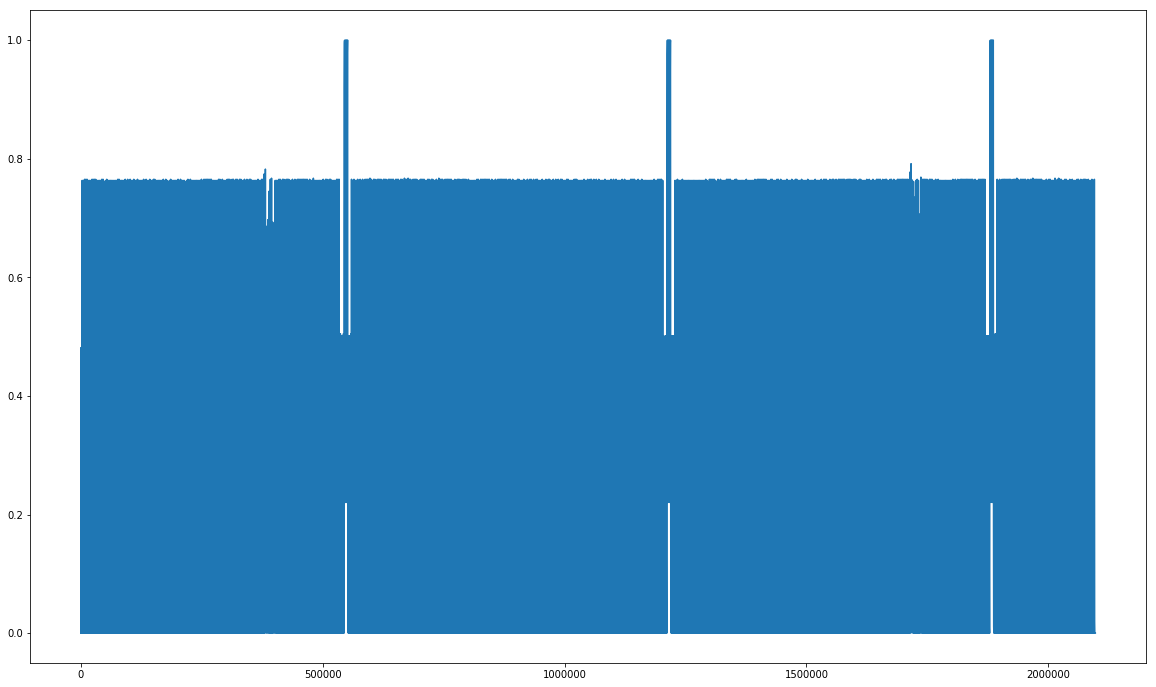

In [26]:
# This shows some nice patterns.  The glitches near the odd #'d syncs
plt.plot(output_syncf)

In [27]:
# state 1: find vsync and first full hsync.  determine which line it is as well...

loc = 0
imglen = (int)((filterset['freq_hz'] / 59.976) * 1.25)

if (loc + imglen) > len(output_syncf):
    print("get more data")

# find the next sync point.  should be > .9
syncloc = np.argmax(output_syncf[loc:loc+imglen])

if np.max(output_syncf[loc:loc+imglen]) < .9:
    print("oops.  can't find a good sync")



In [28]:
# does this actually need to look backwards?  *maybe* on the first use...
def findburstfromsync(syncf, center, forward):
    # we don't know where *in* the vsync the filtered peak is, but we can look -/+ 3 lines from any point of it 
    # to find the previous and next syncs

    ilinepx = int(filterset['line_px'])
    
    burstloc = center
    if forward:
        burstloc += (ilinepx * 3)
    else:
        burstloc -= (ilinepx * 3)
        
    lastpeak = burstloc
    
    while True:
        if forward:
            searchend = int(burstloc + (ilinepx / 1.5))
            if searchend > len(output_syncf):
                return None
            tmp = output_syncf[burstloc:searchend]
        else:
            searchend = int(burstloc - (ilinepx / 1.5))
            if searchend < 0:
                return None
            tmp = output_syncf[searchend:burstloc]
            
        peaklevel = np.max(tmp)
        
        travel = (ilinepx // 10)
        
        if peaklevel < .3: # peak is too small to be anything, move 1/2 line
            travel = (ilinepx // 2)
            peakloc = lastpeak
        elif forward: # accept peak
            peakloc = burstloc + np.argmax(tmp)
        else:
            peakloc = searchend + np.argmax(tmp)
        
        print(burstloc, peakloc, peaklevel)

        if peaklevel > .7:
            return peakloc, np.abs(peakloc - lastpeak) > (filterset['line_px'] * .65)

        lastpeak = peakloc
        
        if forward:
            burstloc = peakloc + travel
        else:
            burstloc = peakloc - travel
            
#        break
        
nextline, ishalf = findburstfromsync(output_syncf, syncloc, True)
#findburstfromsync(output_syncf, syncloc, False) 
    

559171 559559 0.765221768803


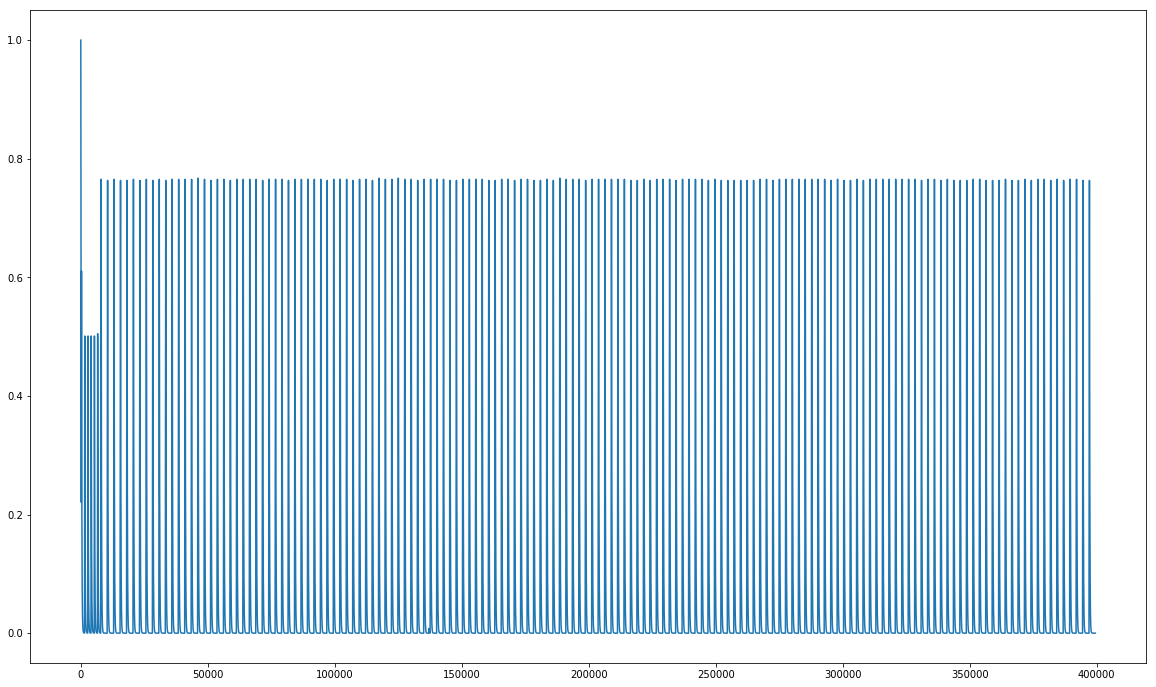

In [29]:
plt.plot(output_syncf[syncloc:syncloc+399430])

In [30]:
nextline, ishalf

(559559, False)

In [31]:
reduced = (output - minn) / hz_ire_scale
output_u16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

In [32]:
# state 2: find the (rough) locations of each following line

ilinepx = int(filterset['line_px'])
lines = np.zeros((255 * ilinepx), dtype=np.uint16)

curloc = nextline

lineinfo = [curloc]
for i in range(0, 253):
    prevloc = curloc
    
    curloc += int(filterset['line_px'] * .9)
    offset = np.argmax(output_syncf[curloc:curloc + int(filterset['line_px'] * .2)])
    curloc += offset 
    
    # if the burst doesn't look good, reuse the last one
    is_validlinegap = inrange((curloc - prevloc), filterset['line_px'] * .997, filterset['line_px'] * 1.003)
    validaftersync = (np.max(output[curloc:curloc + 20]) < 8500000) and (np.min(output[curloc:curloc + 20]) >= 7600000)
    if ((output_syncf[curloc] < .7) and not is_validlinegap) or not validaftersync:
        print(i, curloc)
        curloc = prevloc + (lineinfo[-1] - lineinfo[-2])
        
    #print(curloc, output[curloc], output[curloc+8])

    lineinfo.append(curloc)
    
    lines[i * ilinepx:(i * ilinepx)+(curloc - prevloc)] = output_u16[prevloc:curloc]
    
#    if (i == 119):
#        break

In [33]:
m20ire = 8100000-hz_ire_scale*20

In [34]:
# crude zero-crossing calculator.

def calczc(data, start_offset, target, count=10):
    if data[start_offset] < target:
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
    
    if len(locs) == 0:
        return None
        
    x = start_offset + locs[0]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [35]:
lineinfo2 = []

for l in lineinfo:
    zc = calczc(output, l - 5, m20ire, 20)
    
    if zc is None:
        lineinfo2.append(l)
        continue
        
    lineinfo2.append(zc)
    #print(l, output[l], output[l + 1], output[l + 2])
    


In [36]:
# now to get fine sync!

In [37]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 1
        arr = np.linspace(0, dist, num=dist)
#       print(arr, dist, begin, ibegin, ibegin + dist)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist])
        arrout = np.linspace(begin - ibegin, linelen, tgtlen)

        return interpolate.splev(arrout, spl)
    

In [38]:
def downscale(data, lineinfo):
    dsout = np.zeros((len(lineinfo) * ilinepx), dtype=np.double)    

    sfactor = []

    for l in range(0, len(lineinfo) - 1):
        scaled = scale(data, lineinfo[l] + 0, lineinfo[l + 1], 910)
        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)

        dsout[l * 910:(l + 1)*910] = scaled
        
    return dsout, sfactor

lines, sfactor = downscale(output, lineinfo2)
    
reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)


(230230,)
uint8 (253, 910) (253, 910)


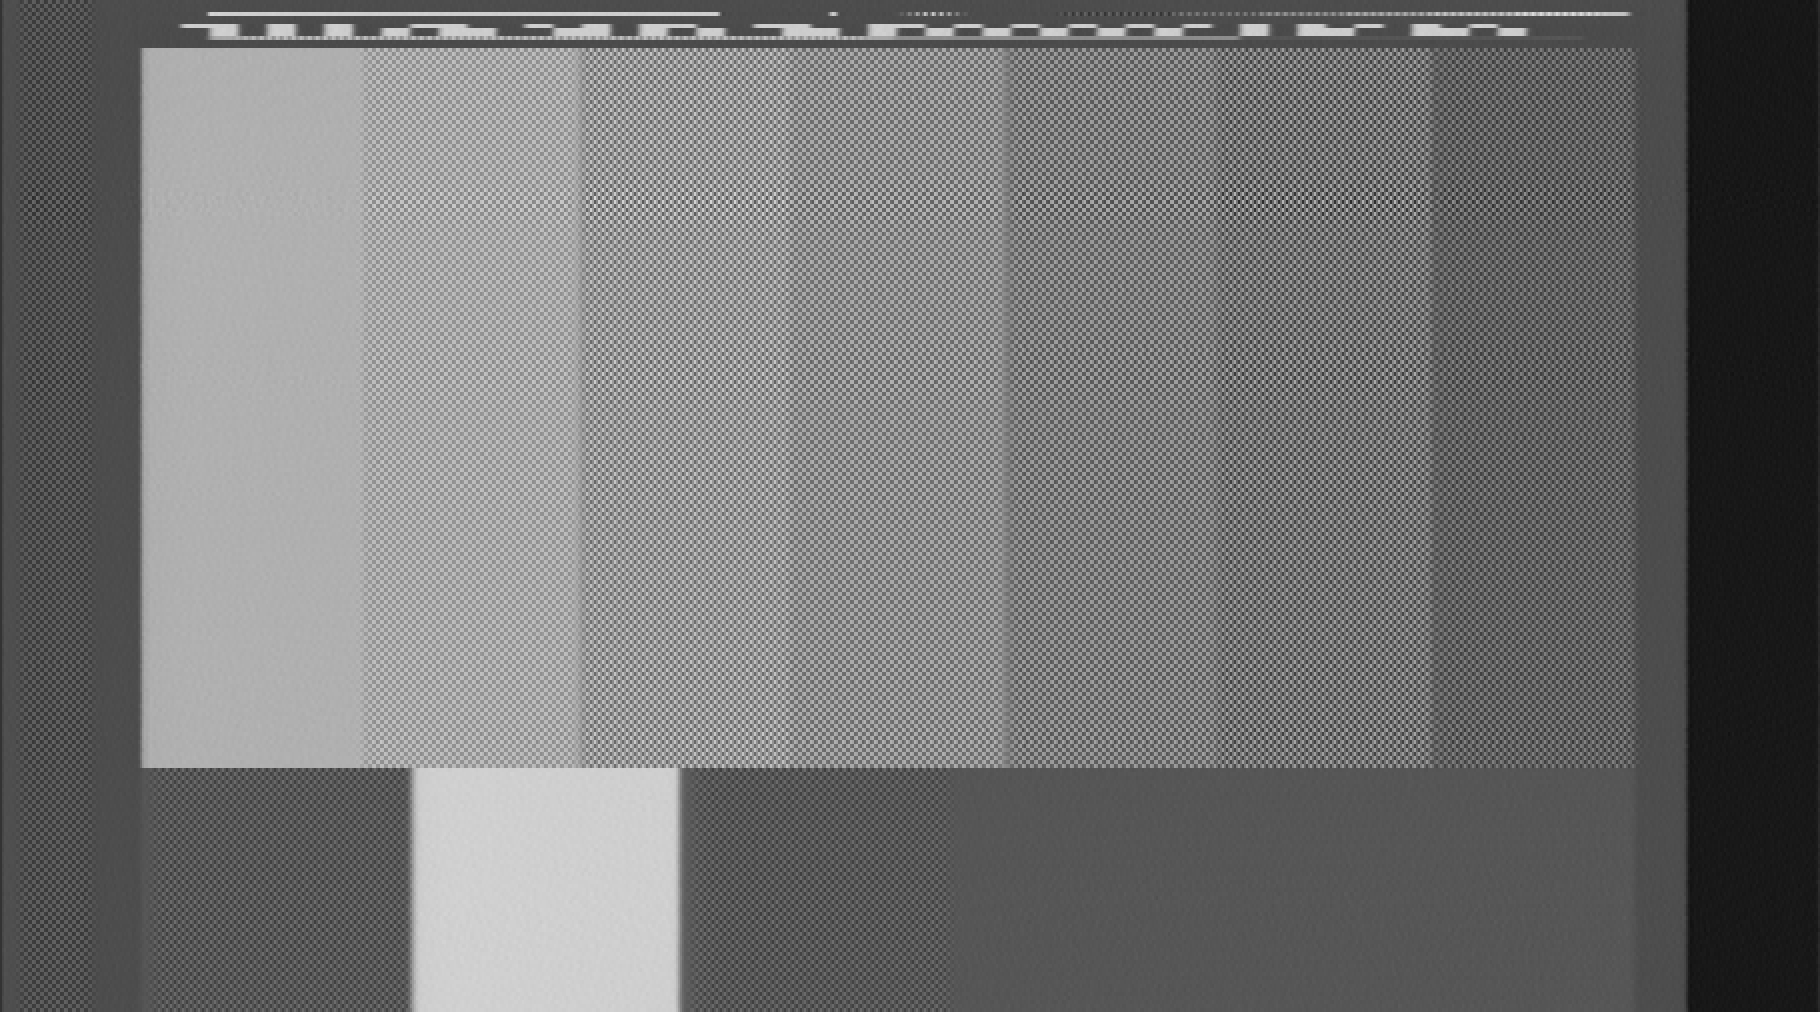

In [39]:
drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [40]:
def phasecorrect(sdata, lineinfo, mult = 0.25):
    loutput = []
    errors = []

    for l in range(0, len(lineinfo) - 1):
        subset = sdata[l * 910: (l + 1) * 910][5:60]

        if (np.min(subset) < 7600000) or (np.max(subset) > 8500000):
            loutput.append(lineinfo[l])
            errors.append(0)
            continue
        
        peaks = np.where(np.abs(subset - 8100000) > 150000)[0]
        toffset = 0

        for loc in peaks:
            zp = calczc(subset, loc, 8100000)

            if zp is not None:
                offset = (zp - loc - 1)
                toffset += offset
            else:
                offset = 0

    #        print(zp, offset)

        errors.append(toffset)
        #print(l, toffset / len(peaks) * sfactor[l])

        loutput.append(lineinfo[l] - ((toffset * mult) / len(peaks) * sfactor[l]))

    loutput.append(lineinfo[-1])
    
    return loutput, errors
    

In [41]:
lineinfo_cur = lineinfo2.copy()
#lines, sfactor = downscale(output, lineinfo_cur)

errs = np.zeros((6, len(lineinfo_cur) - 1), dtype=np.double)

for i in range(0, 6):
    lines, sfactor = downscale(output, lineinfo_cur)
    lineinfo_prev = lineinfo_cur
    lineinfo_cur, err = phasecorrect(lines, lineinfo_prev, .35 / (i + 1))
      
    errs[i] = err
    print(np.std(err), np.mean(np.abs(err)), np.max(np.abs(err)))

2.85112715327 3.88501761646 6.82021318373
2.34658080099 1.84466905067 6.82704510483
1.13772797509 0.816950438533 3.66075302746
0.686627603702 0.490328901651 2.84583877609
0.512758822715 0.367047498987 2.49661411853
0.488341773097 0.346435191674 2.1479268989


(230230,)
uint8 (253, 910) (253, 910)


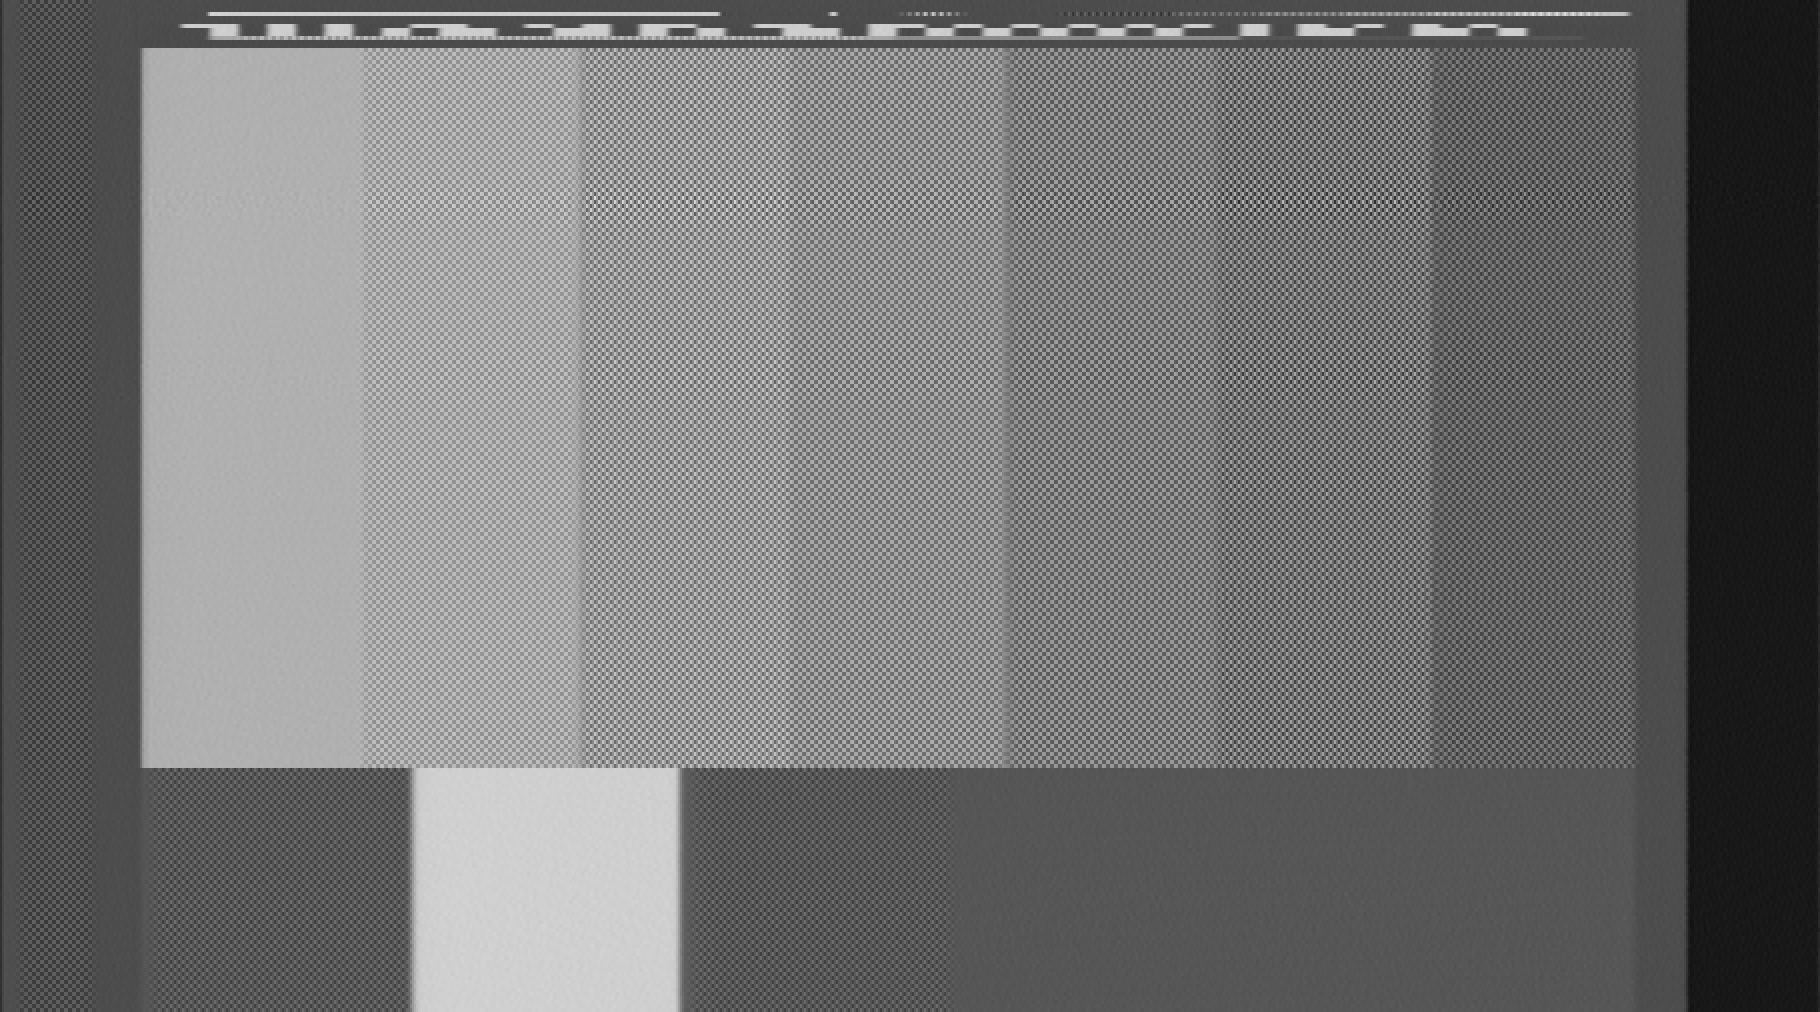

In [42]:
reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

(230230,)
uint8 (253, 910) (253, 910)


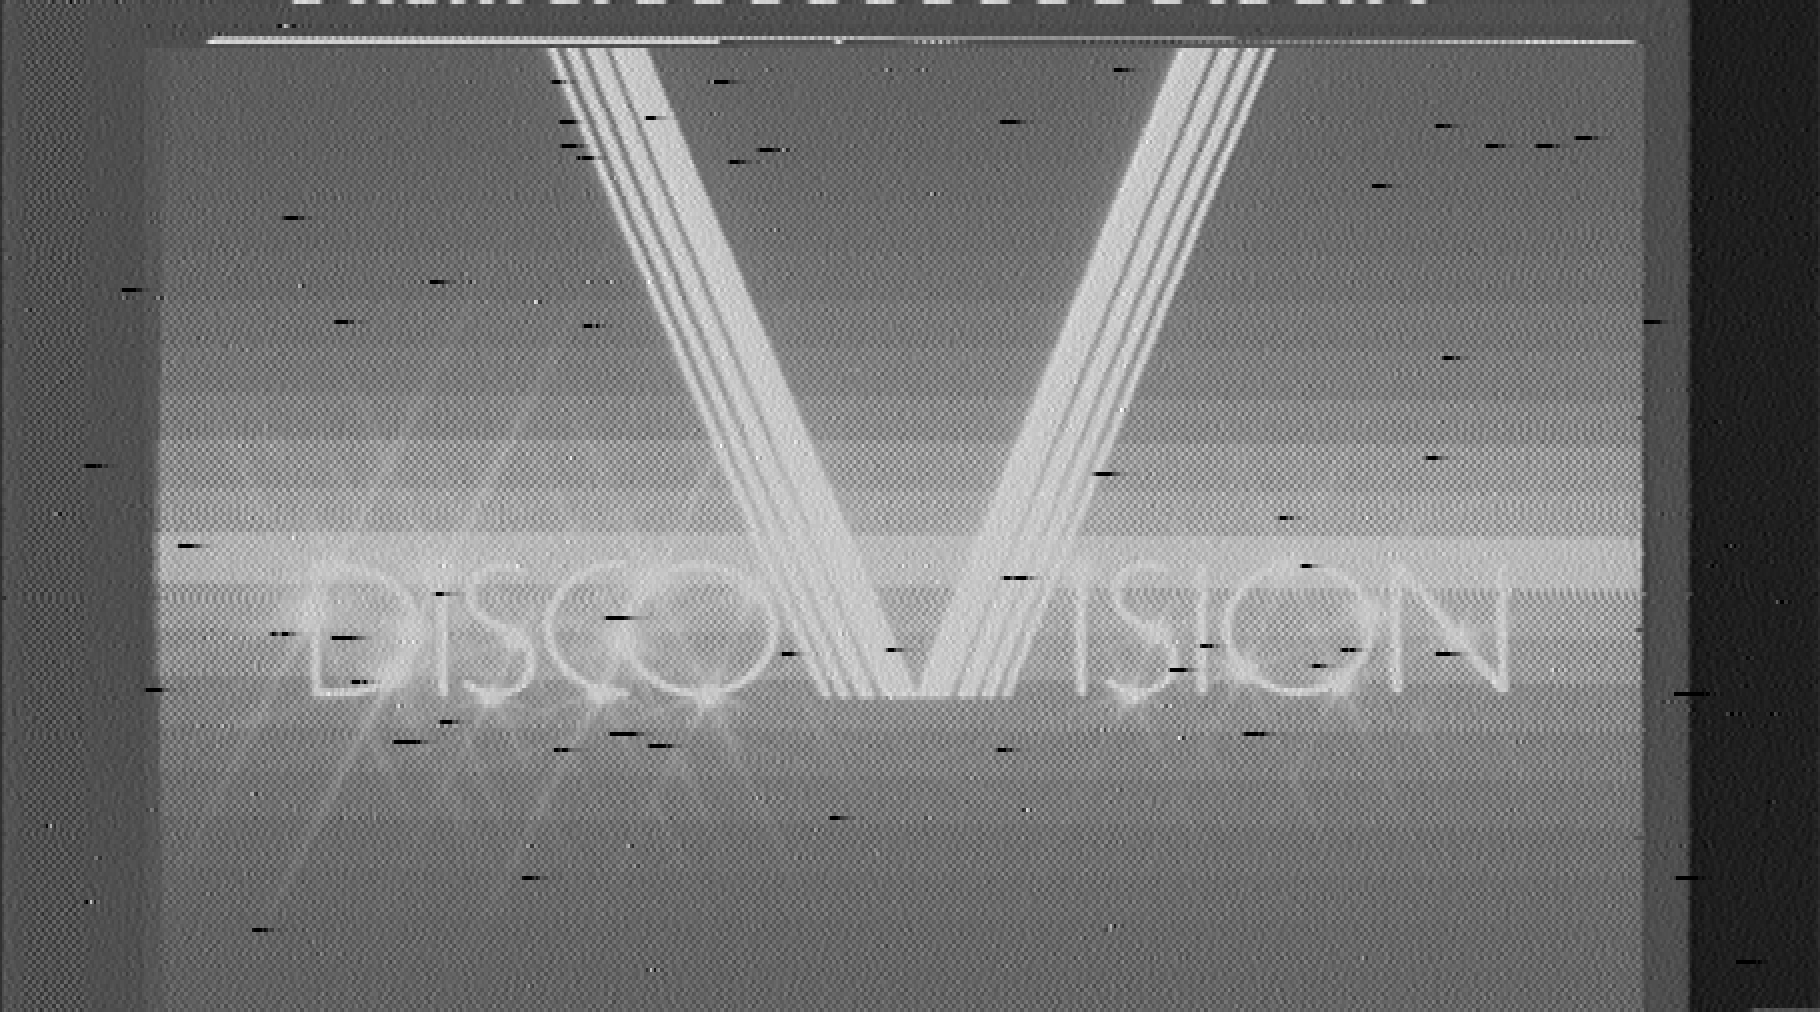

In [120]:
# Example of this code on a rotter :)
reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [110]:
# figure out where vsync is supposed to begin, assuming line start at ire -20:

In [44]:
910/63.5, 58.5*(910/63.5)

(14.330708661417322, 838.3464566929133)

In [45]:
begline = []
endline = []
for l in range(0, len(lineinfo_cur) - 1):
    cline = lines[l * 910:(l + 1) * 910]
    begline.append(calczc(cline, 0, 8000000, 5))
    endline.append(calczc(cline, 840, m20ire, 20))
    if (begline[-1] is None):
        print("b", l)
        begline[-1] = -1
    if (endline[-1] is None):
        print("e", l)
        endline[-1] = 844.25

In [46]:
np.min(begline), np.max(begline), np.mean(begline), np.argmax(begline), np.std(begline)

(0.63584228136613863,
 0.94421865927841309,
 0.79836246686125434,
 82,
 0.055716198111362011)

In [47]:
np.min(endline), np.max(endline), np.mean(endline), np.argmax(endline), np.std(endline)

(842.64784161542741,
 843.23253700875898,
 842.95766677771883,
 41,
 0.12051323529698582)

In [48]:
lineinfo2[147] - lineinfo2[146], lineinfo_cur[147] - lineinfo_cur[146]

(2542.5001172033371, 2542.5606762147509)

In [49]:
lineinfo2[120] - lineinfo2[119], lineinfo_cur[120] - lineinfo_cur[119]

(2542.8612982147606, 2542.8797708646161)

In [50]:
endline[147]

842.79849688238085

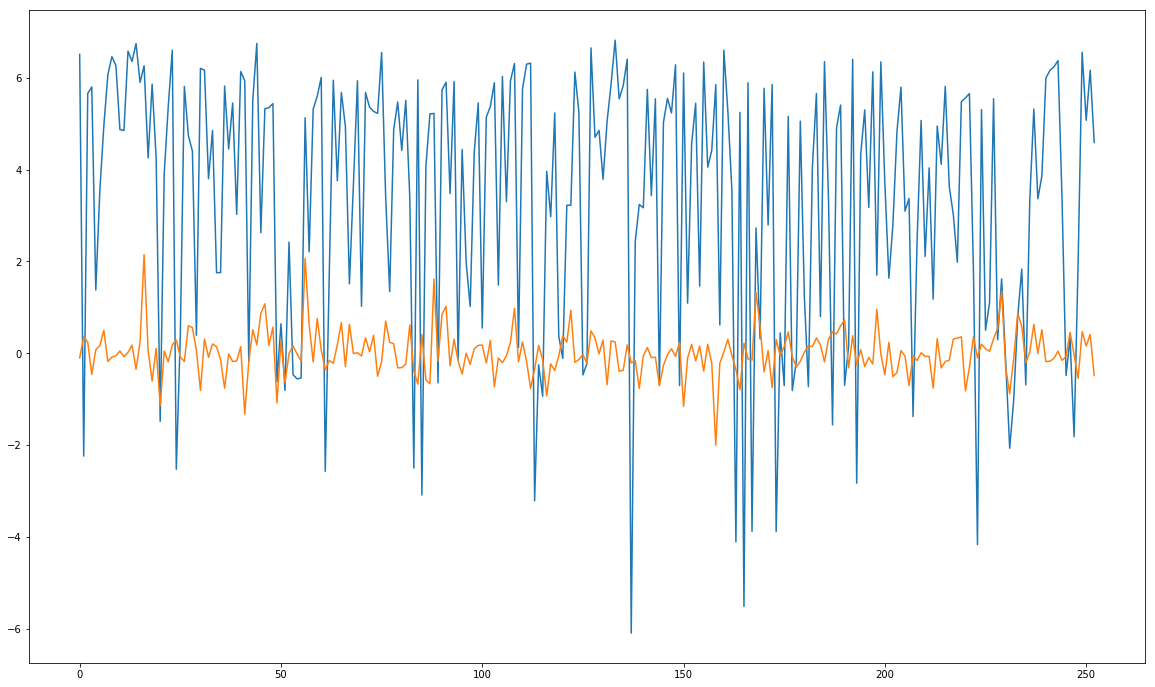

In [51]:
plt.plot(errs[0])
plt.plot(errs[-1])

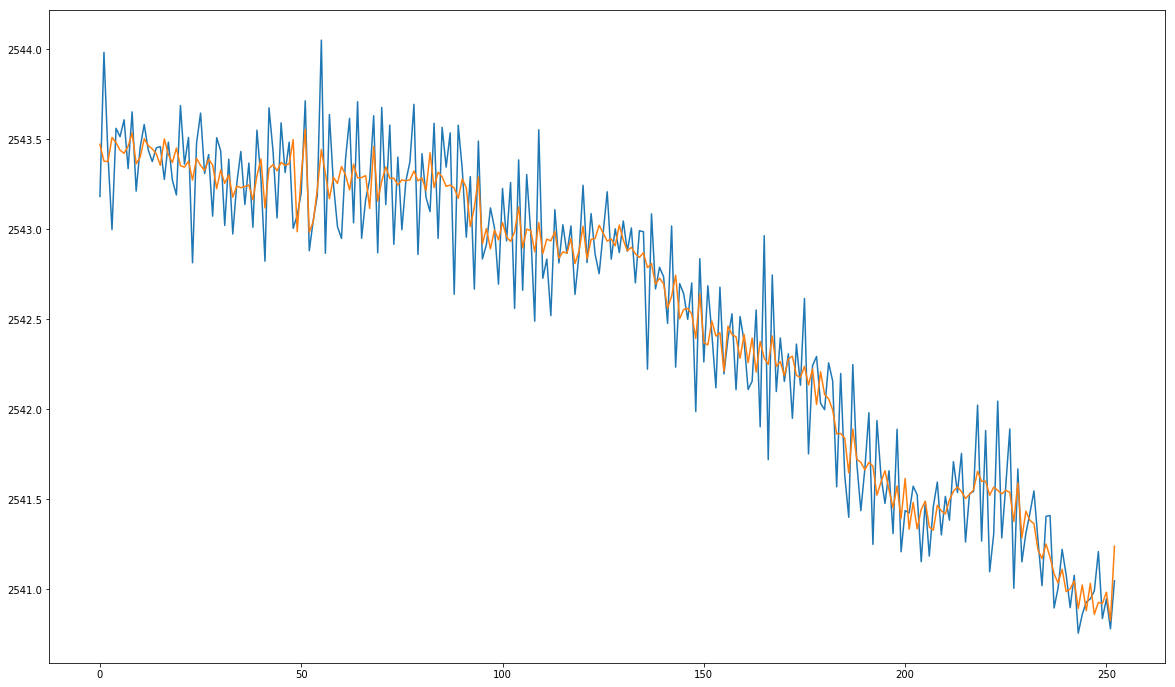

In [53]:
plt.plot(np.diff(lineinfo2))
plt.plot(np.diff(lineinfo_cur))